<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-2

In [7]:
#@title Current Date
Today = '2021-08-22' #@param {type:"date"}


In [8]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20214537" #@param {type:"string"}
Student_full_name = "Tom Keane" #@param {type:"string"}
#@markdown ---

In [9]:
#@title Notebook information
Notebook_type = 'Example' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# INTRODUCTION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [10]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [12]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [13]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-ET5003/ET5003_SEM1_2021-2/tree/main/Week-3). 

2. Upload the dataset into your folder.



The challenge is to predict the final price of each house.

### Importing Datasets

In [14]:
def import_datasets(git_link = 'https://raw.githubusercontent.com/tomkeane07/AI-Projects-UL/main/semester3/MachineLearningApplications/PiecewiseRegression'):
  return {
      'house_test' : pd.read_csv(git_link+'/house_test.csv'),
      'house_train' : pd.read_csv(git_link+'/house_train.csv'),
      'true_price'  : pd.read_csv(git_link+'/true_price.csv')}

try:
  dbs
except:
  dbs = import_datasets()

# split data into training and test
from sklearn.model_selection import train_test_split

# training: 70% (0.7), test: 30% (0.3) 
# you could try any other combination 
# but consider 50% of training as the low boundary
# X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)

dftest = dbs['house_test' ]
dftrain =  dbs['house_train']
dfcost = dbs['true_price']

### Initial datasets inspection

In [15]:
# show first data frame rows 
display(dftrain.tail())

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,price,property_category,property_type,surface
2977,12428232,Ballsbridge,2.0,2.0,C3,Dublin,Sherry FitzGerald are delighted to present Apa...,prod,NaN,Prime Location\nManagement Co: Core Property M...,53.338738,-6.237199,NaN,415000.0,sale,apartment,56.0
2978,12428240,Rialto,1.0,3.0,B2,Dublin,Property Team Patrick Moran is delighted to pr...,prod,NaN,Totally refurbished to the highest standard. \...,53.335793,-6.294268,NaN,485000.0,sale,terraced,101.0
2979,12428247,Smithfield,1.0,2.0,C3,Dublin,Earnest estate agents are delighted to present...,prod,Wired for Cable Television,OVERLOOKING THE RIVER LIFFEY \n3RD FLOOR APART...,53.346098,-6.276856,NaN,299000.0,sale,apartment,55.6
2980,12428254,Foxrock,2.0,3.0,C3,Dublin,Janet Carroll Estate Agents are pleased to pre...,prod,"Parking,Gas Fired Central Heating",None,53.273518,-6.178500,NaN,495000.0,sale,end-of-terrace,97.0
2981,12428358,Terenure,2.0,3.0,D2,Dublin,ON VIEW SATURDAY 7 TH MARCH 2020 11:30 AM - 12...,prod,NaN,Charming three-bedroom family home\nMinutes aw...,53.310073,-6.325158,NaN,525000.0,sale,semi-detached,129.3


In [16]:
display(dftest.tail())

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,property_category,property_type,surface
495,12369815,Ringsend,1.0,2.0,NaN,Dublin,***SUPERB LOCATION / PRIVATE PARKING OPTION AV...,prod,NaN,Adjacent to Grand Canal Dock\nClose to a host ...,53.342207,-6.226101,NaN,sale,apartment,65.0
496,12416011,Cabinteely,3.0,5.0,E1,Dublin,"OPEN VIEWING SATURDAY 7TH MARCH, 10.00AM - 10....",prod,"Parking,Alarm,Oil Fired Central Heating",Excellently presented 5 bedroom family home\nE...,53.261475,-6.147720,NaN,sale,detached,191.3
497,12232222,Artane,1.0,3.0,G,Dublin,Sherry FitzGerald is delighted to present to t...,prod,NaN,Detached Family Home\nOnly One Owner\nMature C...,53.391619,-6.205157,NaN,sale,detached,105.0
498,11905630,Clontarf,2.0,4.0,E2,Dublin,Modernised yet still in touch with it's period...,prod,"Parking,Gas Fired Central Heating,Alarm,Wired ...",Stunning coastal views.\nExcellent condition t...,53.360578,-6.183701,NaN,sale,end-of-terrace,130.0
499,12394865,Drumcondra,2.0,2.0,C1,Dublin,MOVEHOME ESTATE AGENTS .. are delighted to pre...,prod,NaN,* Spacious two Bedroom master ensuite apartmen...,53.366827,-6.248329,NaN,sale,apartment,71.0


In [17]:
display(dfcost.tail())

,Id,Expected
495,12369815,345000.0
496,12416011,775000.0
497,12232222,360000.0
498,11905630,925000.0
499,12394865,325000.0


In [18]:
display(dftrain.describe())

print("\n\nmissing values _ %")
print(dftrain.isna().sum()* 100 / len(dftrain))
print("_________\nunique values")
print(dftrain.nunique(axis=0))

,ad_id,bathrooms,beds,latitude,longitude,no_of_units,price,surface
count,2.982000e+03,2931.000000,2931.000000,2982.000000,2982.000000,59.000000,2.892000e+03,2431.000000
mean,1.224065e+07,1.998635,2.979188,53.355991,-6.257175,7.440678,5.323536e+05,318.851787
std,5.793037e+05,1.291875,1.468408,0.086748,0.141906,8.937081,5.678148e+05,4389.423136
min,9.968870e+05,0.000000,0.000000,51.458439,-6.521183,0.000000,1.999500e+04,3.400000
25%,1.226813e+07,1.000000,2.000000,53.298929,-6.314064,2.000000,2.800000e+05,74.100000
50%,1.237758e+07,2.000000,3.000000,53.345497,-6.252254,3.000000,3.800000e+05,100.000000
75%,1.240294e+07,3.000000,4.000000,53.388845,-6.196049,8.000000,5.750000e+05,142.000000
max,1.242836e+07,18.000000,27.000000,53.630588,-1.744995,36.000000,9.995000e+06,182108.539008




missing values _ %
ad_id                  0.000000
area                   0.000000
bathrooms              1.710262
beds                   1.710262
ber_classification    22.702884
county                 0.000000
description_block      0.000000
environment            0.000000
facility              67.639168
features               0.000000
latitude               0.000000
longitude              0.000000
no_of_units           98.021462
price                  3.018109
property_category      0.000000
property_type          1.710262
surface               18.477532
dtype: float64
_________
unique values
ad_id                 2982
area                   156
bathrooms               13
beds                    15
ber_classification      16
county                   1
description_block     2976
environment              1
facility                34
features              1882
latitude              2879
longitude             2889
no_of_units             22
price                  355
property_category 

- **no_of_units** can go as there is too little data there.

- **county**, **environment**  can also go as there's only one value for each.
 
- **area** will also have to go as it has too many values to encode

- facility has a lot of missing values. Though this field being missing may be valid data anyway.

- ber_classification may be able to be mapped ordinally.

- One-hot encoding and simple imputation can be applied to the other categories with missing values less than 25 %

- Facility, Features and description_block may have some relevant data based on content length, or other variables, despite their current type being "String"

This data-set has many potential options for pre-processing, but having the data split before pre-processing may lead to issues, so it will be recombined for later.

In [19]:
dropcols = ['no_of_units', 'county', 'environment', 'area', 'ad_id']



### Combining imported dbs to be processed, shuffled and split later.

In [20]:
### join train and test to split later
dftest['price'] = dfcost['Expected']

df = dftrain.append(dftest)

In [21]:
def inspect_data(df, dropcols):
  df = df.drop(df[dropcols], axis=1)

  sns.pairplot(data=df.dropna())
  plt.show()

  display(df.describe())

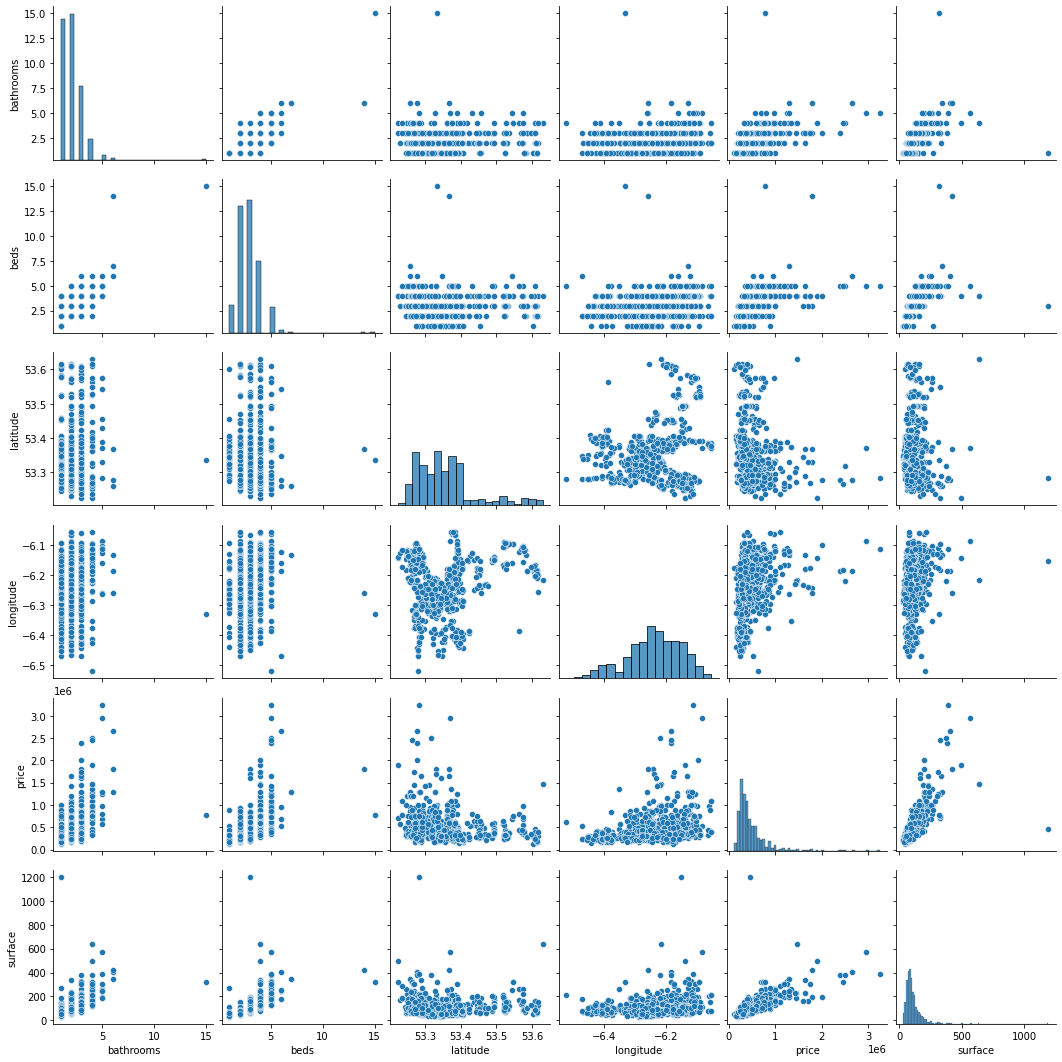

,bathrooms,beds,latitude,longitude,price,surface
count,2931.000000,2931.000000,2982.000000,2982.000000,2.892000e+03,2431.000000
mean,1.998635,2.979188,53.355991,-6.257175,5.323536e+05,318.851787
std,1.291875,1.468408,0.086748,0.141906,5.678148e+05,4389.423136
min,0.000000,0.000000,51.458439,-6.521183,1.999500e+04,3.400000
25%,1.000000,2.000000,53.298929,-6.314064,2.800000e+05,74.100000
50%,2.000000,3.000000,53.345497,-6.252254,3.800000e+05,100.000000
75%,3.000000,4.000000,53.388845,-6.196049,5.750000e+05,142.000000
max,18.000000,27.000000,53.630588,-1.744995,9.995000e+06,182108.539008


In [22]:
inspect_data(dftrain, dropcols)

#### Outliers
- bathrooms and beds both have outliers beyond 7, but there may be other features which explain these outliers, so I will keep them in the df.
- Similarly *surface* has a large outlier. This is investigated below, perhaps it's a site which would explain it's outlier status.

In [23]:
display(dftrain[['property_type', 'surface']].sort_values('surface').dropna())

,property_type,surface
1733,apartment,3.400000
2300,apartment,18.600000
257,studio,22.450000
172,studio,25.000000
2355,apartment,27.500000
...,...,...
178,site,16187.425690
722,site,36178.896416
88,bungalow,72236.387140
99,site,80937.128448


This outlier is a 'site'. It's status as an outlier is not grounds for dropping this sample. 

In [24]:
print("description_block")
print(df[['description_block']][df[['description_block', 'facility', 'features']].notna()].tail(5).values, end='\n\n')

print('facility')
print(df[['facility']][df[['description_block', 'facility', 'features']].notna()].tail(5).values, end="\n\n")

print('features')
print(df[['features']][df[['description_block', 'facility', 'features']].notna()].tail(5).values, end="\n\n")

description_block
[["***SUPERB LOCATION / PRIVATE PARKING OPTION AVAILABLE/ SMALL EXCLUSIVE DEVELOPMENT / RESIDENT ROOF-TOP GARDEN***\n\nKELLY BRADSHAW DALTON are delighted to announce 15 Ropewalk Place, Ringsend, Dublin 4 to the market.\nOn Dublin cities doorstep, yet tucked away at the end of a quiet cul-de-sac, sits the small private and exclusive development of Ropewalk Place. Ropewalk is a wonderful red-brick building consisting of just 23 apartments, off of Cambridge Road. The development was constructed in 2003.\n\nUpon entering the well maintained foyer you are immediately aware of the privacy and seclusion within the building. Strolling through the beautifully manicured communal gardens with pretty paved walkways and stunning decorative flowerbeds you will find apartment 15 to the building on your left.\n\nNo.15 is perched on the second floor accessed via lift or stairs, and is deceptively spacious and very well laid out. There are two large storage units in the hallway, a mus

- Having looked at the '**features**, I have surmised that each feature is marked by a '\n' new line 

- Similarly **facilities** are listed and separated by commas      **,**

- description_block is separated by \n\n  - double new lines


These columns can be used by counting the number of entries for **description_block** and **features**.

**facilities** on the other hand reuses a series of keywords, which can be processed and on-hot -encoded.

 I give Tim Hrisikos full credit for this method, as it is much more sophisticated than my initial idea of counting entries. 

In [25]:
df.drop_duplicates(subset=['ber_classification'])['ber_classification']

0                      NaN
15                      A3
35                      A2
60                      E2
61                       G
62                      C1
64                       F
66                      C2
67                      C3
71                      D2
73                      D1
75                      B2
88                      E1
89     SINo666of2006exempt
101                     B3
356                     B1
425                     A1
Name: ber_classification, dtype: object

ber_classification clearly has a numeric order, and can be mapped ordinally.


## Data Transformations

In [26]:
def col_to_colCount(df, col, divider):
  #this is designed for features and facilities to convert it to a rough count
  # of features, based on how they're typically listed in the df
  print("extracting "+col +"...")
  df[col] = df[col].fillna("")
  df[col] = df[col].apply(lambda x: x.count(divider)+1)
  return df

def sort_facilities(df, col):
  # Courtesy of Tim Hrisikos
  print("extracting facitilities...")
  df[col] = df[col].fillna("")
  df = df.join(
      df[col].str.extractall('([^,]+)')[0].groupby(level=0).apply(pd.value_counts).unstack(fill_value=0).add_prefix('facility_')
      )
  df.drop('facility', axis=1, inplace=True)
  return df

ber_classification_mapper = {
    #Thanks Nigel Portley
    "SINo666of2006exempt": 1,
    "A1": 2,
    "A2": 3,
    "A3": 4,
    "B1": 5,
    "B2": 6,
    "B3": 7,
    "C1": 8,
    "C2": 9,
    "C3": 10,
    "D1": 11,
    "D2": 12,
    "E1": 13,
    "E2": 14,
    "F": 15,
    "G": 16
}


property_category_mapper = {
  "new_development_parent": 1,
  "sale": 2,
}

def drop_cols(df, dropcols):
  print("dropping", end=" ")
  for col in dropcols:
    print(col, end=", ")
    df.drop(col, axis=1, inplace=True)
  print("...")
  return df

def onehotencode(df, col, drop_first=True):
  print("one hot encoding " + col)
  return pd.get_dummies(df, columns=[col], 
                        dummy_na=True, 
                        drop_first=drop_first)
  
def remove_locations_outside_Ire(df):
  # Carlos Siqueira Do Amaral noticed that there are entries from outside of Ireland.
  # This fiunction removes locations outside of Ireland's lat/ long bounds
  print("removing locations outside of Ireland")
  long0, lat0, long1, lat1 = (-9.97708574059, 51.6693012559, -6.03298539878, 55.1316222195)
  return df.loc[(df['longitude'] > long0) & (df['latitude'] > lat0)  & (df['longitude'] < long1) & (df['latitude'] < lat1)]

def frame_coordinates_to_dublin_center(df):
  print("centering coordinates around dublin city center")
  dublat, dublong = 53.350140, -6.266155
  df['dist_from_dub_center'] = (df.longitude - dublong)**2 +(df.latitude - dublat)**2
  df['latitude'] = df.latitude - dublat
  df['longitude'] = df.longitude - dublong
  return df

def treat_data(df, dropcols = []):
  # dropping columns listed below
  df = drop_cols(df, dropcols)
  #filling values. Justifications outlined in Initial datasets inspection
  df['surface'].fillna(df['surface'].median(), inplace=True)
  df['bathrooms'].fillna(df['bathrooms'].median(), inplace=True)
  df['beds'].fillna(df['beds'].median(), inplace=True)
  df['property_category'].fillna(0, inplace=True)
  #converting features. Justifications outlined in Initial datasets inspection
  df = col_to_colCount(df, 'features' ,'\n')
  df = sort_facilities(df, 'facility')
  df = col_to_colCount(df, 'description_block' ,'\n\n')
  df['ber_classification'] = df['ber_classification'].replace(ber_classification_mapper)
  df['ber_classification'].fillna(df['ber_classification'].mean(), inplace=True)
  df['property_category'] = df['property_category'].replace(property_category_mapper)
  df = onehotencode(df, 'property_type', False)
  df.fillna(0,inplace=True)
  # a couple of extra columns added based on local features.
  df = remove_locations_outside_Ire(df)
  df = frame_coordinates_to_dublin_center(df)
  try:
    df = df[(df.price > 0)]
  except:
      pass
  return df

In [27]:
df = treat_data(df, dropcols)

X_train,X_test,y_train,y_test = train_test_split(df.drop(df[['price']],axis=1), df[['price']], test_size=0.3)

print("\nX_train shape",
    X_train.shape,
    X_test.shape,
    y_train.shape,
    y_test.shape
)

dropping no_of_units, county, environment, area, ad_id, ...
extracting features...
extracting facitilities...
extracting description_block...
one hot encoding property_type
removing locations outside of Ireland
centering coordinates around dublin city center

X_train shape (2373, 27) (1017, 27) (2373, 1) (1017, 1)


bathrooms                              0
beds                                   0
ber_classification                     0
description_block                      0
features                               0
latitude                               0
longitude                              0
price                                  0
property_category                      0
surface                                0
facility_Alarm                         0
facility_Gas Fired Central Heating     0
facility_Oil Fired Central Heating     0
facility_Parking                       0
facility_Wheelchair Access             0
facility_Wired for Cable Television    0
property_type_apartment                0
property_type_bungalow                 0
property_type_detached                 0
property_type_duplex                   0
property_type_end-of-terrace           0
property_type_semi-detached            0
property_type_site                     0
property_type_studio                   0
property_type_te

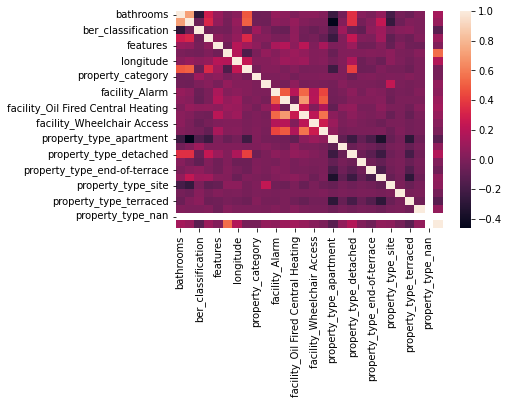

In [28]:
print(df.isna().sum())
display(sns.heatmap(df.corr()))

### final look at the data

####Train

In [29]:
display(X_train.describe())
display(y_train.head())

,bathrooms,beds,ber_classification,description_block,features,latitude,longitude,property_category,surface,facility_Alarm,facility_Gas Fired Central Heating,facility_Oil Fired Central Heating,facility_Parking,facility_Wheelchair Access,facility_Wired for Cable Television,property_type_apartment,property_type_bungalow,property_type_detached,property_type_duplex,property_type_end-of-terrace,property_type_semi-detached,property_type_site,property_type_studio,property_type_terraced,property_type_townhouse,property_type_nan,dist_from_dub_center
count,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.000000,2373.0,2.373000e+03
mean,1.991993,2.973451,10.687511,11.098188,6.058154,0.004754,0.007744,1.998314,290.872051,0.155499,0.271808,0.040034,0.384745,0.028234,0.183734,0.269279,0.026549,0.128529,0.019806,0.079646,0.260008,0.017278,0.000843,0.188791,0.009271,0.0,1.423586e-02
std,1.261849,1.471386,2.876895,7.676812,3.789685,0.076544,0.091106,0.041030,4374.660037,0.373907,0.475222,0.196080,0.543134,0.165676,0.402297,0.443679,0.160794,0.334749,0.139363,0.270801,0.438731,0.130332,0.029025,0.391425,0.095859,0.0,1.712121e-02
min,0.000000,0.000000,1.000000,1.000000,1.000000,-0.135913,-0.255028,1.000000,18.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,5.129816e-07
25%,1.000000,2.000000,9.000000,5.000000,1.000000,-0.051909,-0.043998,2.000000,77.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.220255e-03
50%,2.000000,3.000000,10.691160,10.000000,7.000000,-0.007120,0.015573,2.000000,99.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,7.006516e-03
75%,3.000000,4.000000,12.000000,16.000000,9.000000,0.036734,0.069647,2.000000,128.900000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.078424e-02
max,18.000000,27.000000,16.000000,50.000000,11.000000,0.280448,0.211436,2.000000,182108.539008,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,8.115278e-02


,price
2367,795000.0
204,5750000.0
26,495000.0
931,350000.0
2875,325000.0


####Test

In [31]:
display(X_test.head())
display(y_test.head())

,bathrooms,beds,ber_classification,description_block,features,latitude,longitude,property_category,surface,facility_Alarm,facility_Gas Fired Central Heating,facility_Oil Fired Central Heating,facility_Parking,facility_Wheelchair Access,facility_Wired for Cable Television,property_type_apartment,property_type_bungalow,property_type_detached,property_type_duplex,property_type_end-of-terrace,property_type_semi-detached,property_type_site,property_type_studio,property_type_terraced,property_type_townhouse,property_type_nan,dist_from_dub_center
459,1.0,2.0,9.0,5,11,-0.006060,-0.006381,2,61.4,0.0,1.0,0.0,1.0,0.0,2.0,0,0,0,0,0,0,0,0,1,0,0,0.000077
2665,1.0,4.0,13.0,21,1,-0.058183,-0.032846,2,123.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0.004464
1276,3.0,5.0,8.0,19,4,-0.018551,-0.013253,2,175.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0.000520
2248,1.0,4.0,1.0,4,1,-0.021619,0.007176,2,96.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0.000519
418,3.0,4.0,14.0,19,9,-0.072611,0.112706,2,155.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0.017975


,price
459,325000.0
2665,535000.0
1276,650000.0
2248,750000.0
418,645000.0


# PIECEWISE REGRESSION

## Full Model

In [32]:
# select some features columns just for the baseline model
# assume not all of the features are informative or useful
# in this exercise you could try all of them if possible

# featrain = ['feature_1','feature_2','feature_3','cost']
# dropna: remove missing values
df_subset_train = X_train.dropna(axis=0)

# featest = ['feature_1','feature_2','feature_3']
df_subset_test = X_test.dropna(axis=0)

In [33]:
print('Number of nan in df_subset_train dataset: ',X_train.isnull().sum().sum())
print('Number of nan in df_subset_test dataset: ',X_test.isnull().sum().sum())

Number of nan in df_subset_train dataset:  0
Number of nan in df_subset_test dataset:  0


In [34]:
# train set, input columns
Xs_train = X_train.iloc[:,0:-1].values 
# train set, output column, cost
ys_train = y_train.iloc[:,-1].values.reshape(-1,1)   

# test set, input columns
Xs_test = X_test.iloc[:,0:-1].values 
# test set, output column, cost
ys_test = y_test.iloc[:,0:-1].values

In [35]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1
sc = StandardScaler()

Xss_train = np.hstack([Xs_train,Xs_train[:,[2]]**2])
xscaler = sc.fit(Xss_train)
Xn_train = xscaler.transform(Xss_train)

Xss_test = np.hstack([Xs_test,Xs_test[:,[2]]**2])
Xn_test = xscaler.transform(Xss_test)

ylog = np.log(ys_train.astype('float'))
yscaler = StandardScaler().fit(ylog)
yn_train = yscaler.transform(ylog)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Finished [100%]: Average Loss = 2,406


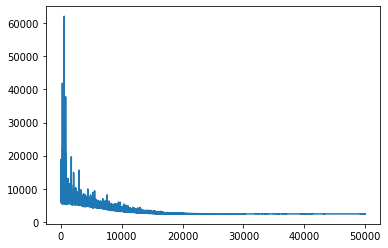

In [36]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, Xn_train.T)
    #likelihood, be sure that observed is a 1d vector
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])

    

#number of iterations of the algorithms
iter = 50000 

# run the model
with model:
    approximation = pm.fit(iter,method='advi')
    
# check the convergence
plt.plot(approximation.hist);    

In [37]:
# samples from the posterior
posterior = approximation.sample(5000)

# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print("MAE = ",(np.mean(abs(y_pred_BLR - y_test.price.values))))
print("MAPE = ",(np.mean(abs(y_pred_BLR - y_test.price.values) / y_test.price.values)))

MAE =  166872.22899241428
MAPE =  0.27203744907607513


## Clustering

### Full Model

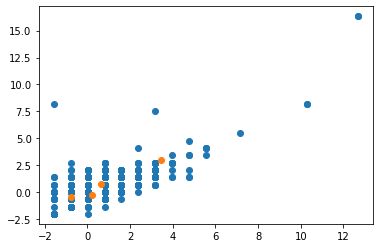

In [38]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4)

# training gaussian mixture model 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4)
# clustering by features 1, 2
ind=[0,1]
X_ind = np.vstack([Xn_train[:,ind],Xn_test[:,ind]])
# Gaussian Mixture
gmm.fit(X_ind)
# plot blue dots
plt.scatter(X_ind[:,0],X_ind[:,1])
# centroids:  orange dots
plt.scatter(gmm.means_[:,0],gmm.means_[:,1])

### Clusters

In [39]:
# train clusters

# train clusters
clusters_train = gmm.predict(Xn_train[:,ind])
unique_train, counts_train = np.unique(clusters_train, return_counts=True)
dict(zip(unique_train, counts_train))

{0: 439, 1: 1022, 2: 886, 3: 26}

In [40]:
# test clusters
clusters_test = gmm.predict(Xn_test[:,ind])
unique_test, counts_test = np.unique(clusters_test, return_counts=True)
dict(zip(unique_test, counts_test))

{0: 189, 1: 449, 2: 367, 3: 12}

In [41]:
# cluster 0
Xn0 = Xn_train[clusters_train==0,:]
Xtestn0 = Xn_test[clusters_test==0,:]

ylog0 = np.log(ys_train.astype('float')[clusters_train==0,:])
yscaler0 = StandardScaler().fit(ylog0)
yn0 = yscaler0.transform(ylog0)

In [42]:
# cluster 1
Xn1 = Xn_train[clusters_train==1,:]
Xtestn1 = Xn_test[clusters_test==1,:]
ylog1 = np.log(ys_train.astype('float')[clusters_train==1,:])
yscaler1 = StandardScaler().fit(ylog1)
yn1 = yscaler1.transform(ylog1)


In [43]:
# cluster 2
Xn2 = Xn_train[clusters_train==2,:]
Xtestn2 = Xn_test[clusters_test==2,:]
ylog2 = np.log(ys_train.astype('float')[clusters_train==2,:])
yscaler2 = StandardScaler().fit(ylog2)
yn2 = yscaler2.transform(ylog2)

In [44]:
# cluster 3
Xn3 = Xn_train[clusters_train==3,:]
Xtestn3 = Xn_test[clusters_test==3,:]
ylog3 = np.log(ys_train.astype('float')[clusters_train==3,:])
yscaler3 = StandardScaler().fit(ylog3)
yn3 = yscaler3.transform(ylog3)

## Piecewise Model

In [45]:
# model_0
with pm.Model() as model_0:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn0.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn0.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn0[:,0])

with model_0:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior   
posterior0 = approximation.sample(5000)

Finished [100%]: Average Loss = 600.89


In [46]:
# model_1
with pm.Model() as model_1:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn1.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn1.T)
  # likelihood, # 
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn1[:,0])
  
with model_1:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior1 = approximation.sample(5000)

Finished [100%]: Average Loss = 1,285.1


In [47]:
# model_2
with pm.Model() as model_2:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn2.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  # linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn2.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn2[:,0])
    
with model_2:
  # iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior2 = approximation.sample(5000)

Finished [100%]: Average Loss = 1,075.5


In [48]:
# model_3
with pm.Model() as model3:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn3.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  mu = alpha + pm.math.dot(beta, Xn3.T)#linear regression model in matrix form
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn3[:,0])
    
with model3:
  # number of iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior     
posterior3 = approximation.sample(5000)

Finished [100%]: Average Loss = 152.74


In [49]:
# Posterior predictive checks (PPCs)
def ppc(alpha,beta,sigma, X,  nsamples=500):
    #we select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        #we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T +np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
    return Ypred

##Simulations

In [50]:
def plot_simulation(Ypred, ylog):
  for i in range(Ypred.shape[0]):
      az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
  az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
  #plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
  #plt.xlim([0,10e7])
  az.plot_dist(ylog,label='true observations');
  plt.legend()
  plt.xlabel("log(y) - output variable")
  plt.ylabel("density plot");

### Only Cluster {0..3}

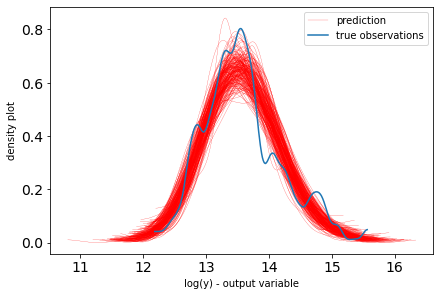

In [51]:
#Simulation
Ypred0 = yscaler0.inverse_transform(ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200))
plot_simulation(Ypred0, ylog0)

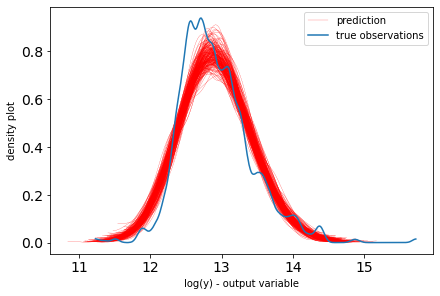

In [52]:
#Simulation
Ypred1 = yscaler1.inverse_transform(ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200))
plot_simulation(Ypred1, ylog1)

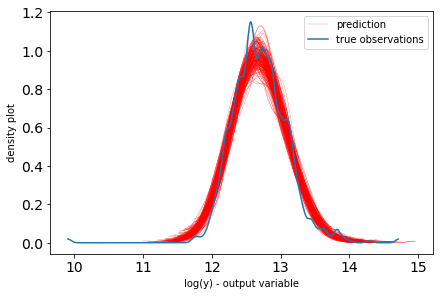

In [53]:
#Simulation
Ypred2 = yscaler2.inverse_transform(ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200))
plot_simulation(Ypred2, ylog2)

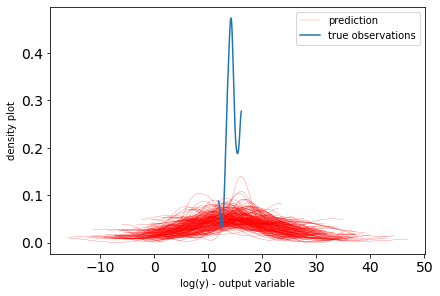

In [54]:
#Simulation
Ypred3 = yscaler3.inverse_transform(ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200))
plot_simulation(Ypred3, ylog3)

## Overall

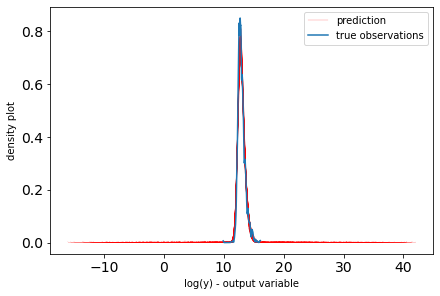

In [55]:
# posteriors
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,  nsamples=200)

# simulation
Ypred = np.hstack([ yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3)])

# prediction
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})

# plot
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
ylog=np.vstack([ylog0,ylog1,ylog2,ylog3])
az.plot_dist(ylog,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Test set performance

In [56]:
# cluster 0
y_pred_BLR0 = np.exp(yscaler0.inverse_transform(np.mean(posterior0['alpha']) 
              + np.dot(np.mean(posterior0['beta'],axis=0), Xtestn0.T)))
print("Size Cluster0", np.sum(clusters_test==0), ", MAE Cluster0=",
      (np.mean(abs(y_pred_BLR0 - y_test.price.values[clusters_test==0]))))

# cluster 1
y_pred_BLR1 = np.exp(yscaler1.inverse_transform(np.mean(posterior1['alpha']) 
              + np.dot(np.mean(posterior1['beta'],axis=0), Xtestn1.T)))
print("Size Cluster1", np.sum(clusters_test==1), ", MAE Cluster1=",
      (np.mean(abs(y_pred_BLR1 - y_test.price.values[clusters_test==1]))))

# cluster 2
y_pred_BLR2 = np.exp(yscaler2.inverse_transform(np.mean(posterior2['alpha']) 
              + np.dot(np.mean(posterior2['beta'],axis=0), Xtestn2.T)))
print("Size Cluster2", np.sum(clusters_test==2), ", MAE Cluster2=",
      (np.mean(abs(y_pred_BLR2 - y_test.price.values[clusters_test==2]))))

# cluster 3
y_pred_BLR3 = np.exp(yscaler3.inverse_transform(np.mean(posterior3['alpha']) 
              + np.dot(np.mean(posterior3['beta'],axis=0), Xtestn3.T)))
print("Size Cluster3", np.sum(clusters_test==3), ", MAE Cluster3=",
      (np.mean(abs(y_pred_BLR3 - y_test.price.values[clusters_test==3]))))

# joint
joint=np.hstack([abs(y_pred_BLR0 - y_test.price.values[clusters_test==0]),
                 abs(y_pred_BLR1 - y_test.price.values[clusters_test==1]),
                 abs(y_pred_BLR2 - y_test.price.values[clusters_test==2]),
                 abs(y_pred_BLR3 - y_test.price.values[clusters_test==3])])

# MAE
print("MAE=",np.mean(joint))

Size Cluster0 189 , MAE Cluster0= 343280.6026391323
Size Cluster1 449 , MAE Cluster1= 127989.0102716635
Size Cluster2 367 , MAE Cluster2= 70167.5255519138
Size Cluster3 12 , MAE Cluster3= 545374.3821236402
MAE= 152058.08650325364


### PPC on the Test set



(10.0, 16.0)

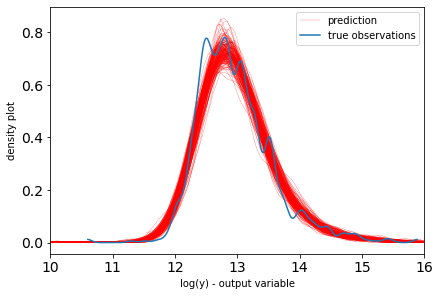

In [57]:
## Posterior predictive checks (PPCs)

num_samples2 = 200
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xtestn0, nsamples=num_samples2)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xtestn1, nsamples=num_samples2)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xtestn2, nsamples=num_samples2)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xtestn3, nsamples=num_samples2)

# Stack arrays in sequence horizontally (column wise)
Ypred = np.hstack([yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3)])

# plot prediction shape
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
# label
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")

# true observations
az.plot_dist(np.log(y_test),label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");
plt.xlim(10, 16)

# SUMMARY



I spent a lot of time on the pre-processing steps for this Dataset.

Initial issues with the dataset were:

- It was already split before pre-processing
- There were simple pre-processing steps, such as removing useless columns
- Converting data to a useable form by simply on-hot-encoding, which could be done for **property_type**, or mapping **ber_classification** ordinally.
- Recognising that **description_block**, **facility** and **features** may store useful information despite their current state as long Strings.

The addition of more columnns had a noted improvement in the performance of the Piecewise Regression model. Initial drafts of this dataset used simple counters for **features** and did not store 'property_type' as a one-hot-encoded feature, which had the model scoring ~500k MAE regularly. With the addition of these features, the model scoers much better at ~150k MAE.

[wiki/Segmented_regression](https://en.wikipedia.org/wiki/Segmented_regression) says that Segmented regression can be performed on multivariate data by partitioning the various independent variables. Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions.

With this in mind, it makes sense that the most important factor in obtaining decent results for predicting price from this dataset was by getting as much useful information from this dataset as possible.